In [0]:
#@title Install prerequsite

!pip install lifelines
!pip install shap

     |████████████████████████████████| 389kB 8.8MB/s 
     |████████████████████████████████| 266kB 9.0MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376832 sha256=aeaa1a46598ef9c8090d37d8fadddd76b37a2cc69cca0a086a578e485efe6ca8
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pathlib import Path

# Change this to where you download the files
DATA = Path("/content/drive/My DriveG0/mini-challenge/data")

In [0]:
import pandas as pd

pfs_train = pd.read_csv(DATA / "pfs_train.txt", sep="\t", index_col="patient_id")
pfs_train.head()

,progression,time_to_progression_or_censor
patient_id,,
TRAIN_0000,1.0,334.0
TRAIN_0001,0.0,1523.0
TRAIN_0002,0.0,121.0
TRAIN_0003,1.0,334.0
TRAIN_0004,1.0,183.0


As part of EDA, we can first construct the overall survival curve using the `lifelines` package.

### Clinical data

Regarding the features we will be using to predict survival, take a look at the clinical table:

In [0]:
clin_train = pd.read_csv(DATA / "clinical_train.txt", sep="\t", index_col="patient_id")

# also load clin_test
clin_test = pd.read_csv(DATA / "clinical_test.txt", sep="\t", index_col="patient_id")

clin_train.head()

,age_at_initial_pathologic_diagnosis,anatomic_neoplasm_subdivision,diagnosis,eastern_cancer_oncology_group,ethnicity,gender,karnofsky_performance_score,laterality,location_in_lung_parenchyma,number_pack_years_smoked,pathologic_M,pathologic_N,pathologic_T,pathologic_stage,race,radiation_therapy,residual_tumor,tobacco_smoking_history
patient_id,,,,,,,,,,,,,,,,,,
TRAIN_0000,81,L-Upper,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],32,M0,N2,T2,Stage IIIA,[Not Available],[Not Available],R2,4
TRAIN_0001,67,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],Peripheral Lung,52,M0,N0,T2,Stage IB,[Not Available],[Not Available],R0,3
TRAIN_0002,79,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],FEMALE,[Not Available],[Not Available],[Not Available],47,M0,N1,T3,Stage IIIA,[Not Available],[Not Available],R2,4
TRAIN_0003,68,L-Upper,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],62,M0,N0,T2,Stage IB,[Not Available],[Not Available],R0,4
TRAIN_0004,66,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],20,M0,N2,T2,Stage IIIA,[Not Available],[Not Available],RX,3


In [0]:
def cat_cont_summary_for_col(col: pd.Series, cat_cutoff: int):
    """Given a :class:`pandas.Series`, calculate its cardinality, and if its
    continuous, show summary statistics; if categorical, show unique values
    
    Arguments
    ---------
    col: pandas.Series
        Input series
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_info: dict
        A dictionary containing info regarding the input series. If the series
    """
    card = col.nunique()
    col_type = "cat" if card <= cat_cutoff else "cont"
    if col_type == "cont":
        col = pd.to_numeric(col, errors="coerce")
    else:
        col = col.astype(str)

    col_info = {
        "cardinality": card,
        "col_type": col_type,
        **col.describe()
    }
    if col_type == "cat":
        col_info["unique_values"] = col.unique()

    return col_info


def cat_cont_summary_for_df(df: pd.DataFrame, cat_cutoff: int = 20):
    """Given a :class:`pandas.DataFrame`, determine whether each column is
    categorical or continuous, and output its summary statistics
    
    Arguments
    ---------
    df: pandas.DataFrame
        Input data frame
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_summary: pandas.DataFrame
        A :class:`pandas.DataFrame` summarizing the statistics of each column
    """
    col_sums = [cat_cont_summary_for_col(df[col], cat_cutoff)
                for col in df.columns]
    col_summary = pd.DataFrame(col_sums)
    col_summary.index = df.columns.values
    return col_summary

In [0]:
import numpy as np

def replace_by_na(col: pd.Series, char: str = "["):
    idx = [char in str(x) for x in col]
    _col = col.copy()
    _col.loc[idx] = np.NaN
    return _col

# perform the same transformation to both clin_train and clin_test
for col in clin_train.columns:
    clin_train[col] = replace_by_na(clin_train[col])
    clin_test[col] = replace_by_na(clin_test[col])


After this process, we can see the values in brackets are all converted to `np.NaN`

In [0]:
cat_cont_summary_for_df(clin_train)

,cardinality,col_type,count,mean,std,min,25%,50%,75%,max,unique,top,freq,unique_values
age_at_initial_pathologic_diagnosis,52,cont,801.0,66.224719,9.476652,33.00,60.0,67.00,73.0,88.0,NaN,NaN,NaN,NaN
anatomic_neoplasm_subdivision,7,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,R-Upper,251.0,"[L-Upper, R-Lower, R-Upper, L-Lower, R-Middle,..."
diagnosis,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Lung Adenocarcinoma,413.0,"[Lung Adenocarcinoma, Lung Squamous Cell Carci..."
eastern_cancer_oncology_group,4,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,nan,488.0,"[nan, 1, 0, 3, 2]"
ethnicity,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NOT HISPANIC OR LATINO,575.0,"[nan, NOT HISPANIC OR LATINO, HISPANIC OR LATINO]"
gender,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,MALE,492.0,"[MALE, FEMALE]"
karnofsky_performance_score,9,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,nan,664.0,"[nan, 0, 80, 90, 50, 100, 70, 40, 60, 20]"
laterality,0,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,nan,816.0,[nan]
location_in_lung_parenchyma,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,nan,469.0,"[nan, Peripheral Lung, Central Lung]"
number_pack_years_smoked,127,cont,622.0,47.547516,28.168011,0.15,28.0,40.25,60.0,180.0,NaN,NaN,NaN,NaN


The following code selected a few columns of interests (arbitrarily), convert the categorical variables to [one-hot encoding](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179), then these data frames are machine-learning ready.

In [0]:
cat_cols = ["diagnosis", "pathologic_M", "pathologic_N", "pathologic_T",
            "radiation_therapy", "residual_tumor"]
cont_cols = ["age_at_initial_pathologic_diagnosis", "tobacco_smoking_history",
             "karnofsky_performance_score"]

In [0]:
# Concatenate categorical variables of interest and numerical variables of
# interest into ml-ready matrices
x_clin_train = pd.concat([pd.get_dummies(clin_train[cat_cols]),
                          clin_train[cont_cols]], axis=1, sort=True)

x_clin_test = pd.concat([pd.get_dummies(clin_test[cat_cols]),
                         clin_test[cont_cols]], axis=1, sort=True)

### RNASeq data

RNASeq data is very straight-forward. We have ~37,000 gene's expression values, all of them are log2 transformed, continuous values. 

In [0]:
ge_train = pd.read_csv(DATA / "rnaseq_train.txt", sep="\t", index_col=0)
ge_test = pd.read_csv(DATA / "rnaseq_test.txt", sep="\t", index_col=0)

ge_train.head()

,TRAIN_0001,TRAIN_0002,TRAIN_0003,TRAIN_0004,TRAIN_0005,TRAIN_0006,TRAIN_0007,TRAIN_0008,TRAIN_0009,TRAIN_0010,TRAIN_0011,TRAIN_0012,TRAIN_0013,TRAIN_0014,TRAIN_0015,TRAIN_0016,TRAIN_0017,TRAIN_0018,TRAIN_0019,TRAIN_0020,TRAIN_0021,TRAIN_0022,TRAIN_0023,TRAIN_0024,TRAIN_0025,TRAIN_0026,TRAIN_0027,TRAIN_0028,TRAIN_0029,TRAIN_0030,TRAIN_0031,TRAIN_0032,TRAIN_0033,TRAIN_0034,TRAIN_0035,TRAIN_0036,TRAIN_0037,TRAIN_0038,TRAIN_0039,TRAIN_0040,...,TRAIN_0776,TRAIN_0777,TRAIN_0778,TRAIN_0779,TRAIN_0780,TRAIN_0781,TRAIN_0782,TRAIN_0783,TRAIN_0784,TRAIN_0785,TRAIN_0786,TRAIN_0787,TRAIN_0788,TRAIN_0789,TRAIN_0790,TRAIN_0791,TRAIN_0792,TRAIN_0793,TRAIN_0794,TRAIN_0795,TRAIN_0796,TRAIN_0797,TRAIN_0798,TRAIN_0799,TRAIN_0800,TRAIN_0801,TRAIN_0802,TRAIN_0803,TRAIN_0804,TRAIN_0805,TRAIN_0806,TRAIN_0807,TRAIN_0808,TRAIN_0809,TRAIN_0810,TRAIN_0811,TRAIN_0812,TRAIN_0813,TRAIN_0814,TRAIN_0815
A1BG,-1.3364,-1.7668,-1.0198,-0.8983,-5.9363,0.3527,-3.0055,-2.3069,-2.1904,-1.2656,-1.3568,-0.7001,-2.8087,-1.0790,-1.5845,-1.2057,-1.6855,-1.1610,0.4233,-3.0186,-1.7536,-1.3744,-0.7374,-4.0285,-3.9233,-3.0484,-1.3048,-2.3104,-3.3131,-4.6724,-2.4712,-2.6891,-4.0212,-3.2784,-1.4477,-3.3057,-1.9225,-3.4339,-2.0238,-1.0988,...,-1.5283,-1.3231,-0.9713,-0.9121,-0.9251,-1.0919,0.2249,-0.6211,-3.3718,-2.0011,-0.9321,-1.0119,-1.3776,-1.4497,-2.0486,-3.0911,0.6557,0.4914,-0.1059,1.1786,-1.9261,-0.4090,-0.3578,-1.9184,0.4643,0.5011,-3.6151,-2.0062,-1.6154,-1.8095,-0.3868,0.4650,0.6863,-1.3412,-0.3093,-0.5301,-1.9589,-3.5359,-1.4197,-1.5915
A1BG-AS1,1.7801,0.7311,1.3790,1.4652,-1.1814,2.4569,-0.3547,0.1567,-0.4160,0.1432,1.0081,1.3865,0.2076,0.8685,-0.4850,1.6472,1.0725,2.1088,1.9816,-0.6165,-0.1687,1.0956,2.0803,-0.5321,-0.7533,0.3515,0.6253,1.5405,0.9846,-1.1280,0.6834,0.9465,-1.7841,0.5763,1.3927,-1.0927,0.3995,-1.5358,0.9184,2.0496,...,1.1689,0.9989,1.5540,1.3656,1.4299,0.8419,2.1225,1.1096,-0.4218,1.5061,1.0749,1.8351,0.4968,1.0799,0.6248,-0.1076,2.4359,2.0764,2.0007,3.6502,0.1443,2.3077,1.1210,0.4837,2.2172,2.0787,0.0854,0.3697,0.9461,0.9194,1.0042,2.7258,3.2015,1.5483,2.0472,1.6936,-0.0731,-1.6099,0.9022,0.3975
A1CF,-4.3104,-6.9762,-6.0047,-2.7964,1.4124,-6.1761,-7.6493,-1.7065,-4.1164,-6.1236,-5.4997,-5.0364,-6.2681,-2.1363,0.8936,-3.2891,4.6606,-3.7933,-3.4446,3.3810,-5.8411,-4.2620,-4.7193,-6.8359,-5.5082,-6.2184,-4.9292,-5.1178,-6.4830,-6.2573,-6.8635,-5.4965,-3.6586,-5.6003,-6.6572,-5.1801,-6.9669,-6.8933,-5.5681,-6.5907,...,-3.8503,-6.5325,-4.5958,-6.6400,-5.4486,-6.3773,-3.6819,-2.6421,-5.2462,-6.7560,-3.7972,-6.3695,-5.7699,-4.0819,-5.3216,-6.5505,-5.4528,-6.1668,-2.2473,-1.6288,-3.4595,-4.7548,-4.3275,-3.9888,2.9479,-4.2104,-5.9370,-4.8136,-4.9846,-6.5644,-6.1147,-2.3639,-4.3047,-6.6266,-1.3841,-2.4416,-4.8975,-3.7423,-2.3708,-5.0510
A2M,10.2830,9.7800,10.0746,11.1037,10.1339,9.2526,9.9767,10.8297,7.7219,10.6659,8.2200,9.3291,8.6852,9.4124,10.7804,10.0078,9.1490,9.0152,7.9316,8.7049,10.1049,10.1162,7.5333,7.9038,7.5614,7.7608,7.6639,8.8712,7.0693,7.6023,8.2200,8.7249,7.1395,8.7063,8.2883,7.4633,7.1652,7.1328,10.0292,8.1975,...,10.7359,10.1068,9.7267,9.8094,9.0229,6.3728,7.9693,7.1119,6.3637,10.8858,7.7719,6.7333,6.4983,7.5106,7.8337,6.9946,7.7285,8.4274,9.0582,9.8243,9.1790,9.2028,11.1617,10.0291,10.1678,7.7649,6.6188,6.4436,8.4880,7.7960,5.2123,10.2018,8.2129,8.3069,7.2597,7.9215,7.8997,9.5837,11.1142,9.2260
A2M-AS1,-0.4035,-0.7095,1.2080,-0.2786,-0.3216,-0.6842,-0.4894,-0.6612,1.3232,0.0663,-0.2903,0.2490,0.1413,0.0721,-1.3330,-0.5834,0.8852,0.1136,0.1161,-0.4684,-1.3175,1.4217,-0.1464,0.4215,0.6279,0.7474,-0.0713,1.8011,-0.0736,0.1177,0.8712,1.4693,0.5024,-0.9954,-0.9292,0.6012,0.8973,0.2462,0.3467,-1.2331,...,-0.0878,0.2619,0.5058,0.4580,0.1856,1.3709,0.4428,1.3093,-0.9486,0.8513,1.2220,0.4507,0.7999,0.6074,0.4772,0.6879,-0.3513,-0.1444,-0.9085,-1.1982,-0.3238,0.0353,0.0649,0.1971,0.4249,-1.4879,-0.2091,-1.1131,0.2249,1.2494,0.7054,-0.3080,-0.9542,-1.6724,0.6538,-0.1474,0.6365,0.3054,-0.3004,-0.6586


In [0]:
cidx_df = pd.read_csv("/content/drive/My Drive/Genomics Project/cidx.txt",
                      sep="\t")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# create gene sets out of top concordance index genes
top_genes_negative = cidx_df.iloc[:400].gene
top_genes_positive = cidx_df.iloc[-400:].gene
_ge = ge_train.loc[pd.concat([top_genes_negative,
                              top_genes_positive], axis=0)].copy()

In [0]:
corr = (_ge.T).corr()

In [0]:
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import squareform

cor_dist = 1 - (corr + 1) / 2
linkage = hc.linkage(squareform(cor_dist), method="average")
labels = cor_dist.columns.values
coexp_set = pd.DataFrame({"cluster": hc.fcluster(linkage, 0.25,"distance"),
                          "gene": labels})

In [0]:
def create_coexp_ge_features(ge, coexp_set, min_gene_set=10):
    geneset_size = coexp_set.groupby("cluster").size()
    geneset_size = geneset_size[geneset_size >= min_gene_set]

    coexp_set_ = coexp_set.set_index("cluster", drop=True)

    tmp = {}
    for gs in geneset_size.index.values:
        genes = coexp_set_.loc[gs].gene.values
        if geneset_size[gs] <= 5:
            gsname = "_".join(list(genes))
        else:
            gsname = genes[0] + "_" + "geneset"
        
        tmp[gsname] = ge.loc[genes].mean(axis=0)
    
    return pd.DataFrame(tmp)

In [0]:
ge_train_feat = create_coexp_ge_features(ge_train, coexp_set)
ge_test_feat = create_coexp_ge_features(ge_test, coexp_set)

In [0]:
# gene sets from https://academiccommons.columbia.edu/doi/10.7916/D8NP22JK 
attractors = {
    "LYM": ["SASH3", "CD53", "NCKAP1L", "LCP2", "IL10RA", "PTPRC", "EVI2B",
            "BIN2", "WAS", "HAVCR2"],
    "CIN": ["TPX2", "KIF4A", "KIFC1", "NCAPG", "BUB1", "NCAPH", "CDCA5",
            "KIF2C", "PLK1", "CENPA"],
    "MES": ["COL3A1", "COL5A2", "COL1A2", "THBS2", "COL5A1", "VCAN", "COL6A3",
            "SPARC", "AEBP1", "FBN1"],
    "END": ["CDH5", "ROBO4", "CXorf36", "CD34", "CLEC14A", "ARHGEF15", "CD93",
            "LDB2", "ELTD1", "MYCT1"]
}

def create_metagenes(ge, genesets):
    tmp = {}
    for gs in genesets:
        genes = [x for x in genesets[gs] if x in ge.index]
        tmp[gs] = ge.loc[genes].mean(axis=0)
    return pd.DataFrame(tmp)

In [0]:
ge_train_feat = pd.concat(
    [ge_train_feat, create_metagenes(ge_train, attractors)], axis=1
)

ge_test_feat = pd.concat(
    [ge_test_feat, create_metagenes(ge_test, attractors)], axis=1
)

We'll just use these top genes to feed to our models. If you want to further improve, you can also try to **combine co-expressed genes into gene set** to reduce co-linearity.

In [0]:
x_ge_train = ge_train_feat.copy()
x_ge_test = ge_test_feat.copy()

### Mutation data

Finally let's take a look at mutation data. The mutation data has the same format of MAF files. Here we'll aggregate the `MODERATE` and `HIGH` impact mutations by genes and pivot it into a matrix.

In [0]:
mut_train = pd.read_csv(DATA / "mut_train.txt", sep="\t")
mut_test = pd.read_csv(DATA / "mut_test.txt", sep="\t")

mut_train.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (56,70,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AA_MAF,AFR_MAF,ALLELE_NUM,AMR_MAF,ASN_MAF,Allele,Amino_acids,BAM_File,BIOTYPE,CANONICAL,CCDS,CDS_position,CLIN_SIG,CONTEXT,COSMIC,Center,Chromosome,Codons,Consequence,DISTANCE,DOMAINS,EAS_MAF,EA_MAF,ENSP,EUR_MAF,EXON,End_Position,Entrez_Gene_Id,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_Adj,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,Existing_variation,Exon_Number,FILTER,...,RefSeq,Reference_Allele,SAS_MAF,SIFT,SOMATIC,SWISSPROT,SYMBOL,SYMBOL_SOURCE,Score,Sequence_Source,Sequencer,Sequencing_Phase,Start_Position,Strand,TRANSCRIPT_STRAND,TREMBL,TSL,Transcript_ID,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,UNIPARC,VARIANT_CLASS,Validation_Method,Validation_Status,Variant_Classification,Variant_Type,Verification_Status,all_effects,cDNA_position,dbSNP_RS,dbSNP_Val_Status,n_alt_count,n_depth,n_ref_count,t_alt_count,t_depth,t_ref_count,patient_id
0,NaN,NaN,1,NaN,NaN,A,NaN,NaN,protein_coding,YES,CCDS37.1,-/1779,NaN,CAGAAGCTAAG,NaN,BI,chr1,NaN,intron_variant,NaN,NaN,NaN,NaN,ENSP00000367830,NaN,NaN,2156152,5590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,...,NM_002744.4,G,NaN,NaN,NaN,Q05513,PRKCZ,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,2156152,+,1.0,NaN,1.0,ENST00000378567,G,A,NaN,NaN,UPI0000169EB7,SNV,NaN,NaN,Intron,SNP,NaN,"PRKCZ,intron_variant,,ENST00000378567,NM_00274...",-/2326,novel,NaN,NaN,24,NaN,4,12,8,TRAIN_0693
1,NaN,NaN,1,NaN,NaN,A,F/L,NaN,protein_coding,YES,CCDS122.1,678/1245,NaN,CCATTCAGGGC,NaN,BI,chr1,ttC/ttA,missense_variant,NaN,Pfam_domain:PF00076;PROSITE_profiles:PS50102;S...,NaN,NaN,ENSP00000240185,NaN,5/6,11020563,23435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_007375.3,C,NaN,deleterious(0),NaN,Q13148,TARDBP,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,11020563,+,1.0,A0A024R4E2,1.0,ENST00000240185,C,A,NaN,NaN,UPI0000136B42,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"TARDBP,missense_variant,p.F226L,ENST0000024018...",1034/5367,novel,NaN,NaN,136,NaN,36,126,90,TRAIN_0693
2,NaN,NaN,1,NaN,NaN,T,S/I,NaN,protein_coding,YES,CCDS30694.2,4157/10128,NaN,GATCAGTCGTC,NaN,BI,chr1,aGt/aTt,missense_variant,NaN,NaN,NaN,NaN,ENSP00000457168,NaN,29/71,43430030,23334,0.000008,0.0,0.0,0.000008,0.0,0.0,0.000015,0.0,0.0,rs765781424,29/71,PASS,...,NM_015284.3,G,NaN,tolerated(0.36),NaN,Q5T011,SZT2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43430030,+,1.0,NaN,5.0,ENST00000562955,G,T,NaN,NaN,UPI0001E24F46,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"SZT2,missense_variant,p.S1386I,ENST00000562955...",4157/12281,rs765781424,NaN,NaN,160,NaN,43,179,136,TRAIN_0693
3,NaN,NaN,1,NaN,NaN,C,H,NaN,protein_coding,YES,CCDS504.1,1287/1470,NaN,GATCATGGAAG,NaN,BI,chr1,caT/caC,synonymous_variant,NaN,TIGRFAM_domain:TIGR00272,NaN,NaN,ENSP00000255108,NaN,5/6,43972276,1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_001384.4,T,NaN,NaN,NaN,Q9BQC3,DPH2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43972276,+,1.0,NaN,1.0,ENST00000255108,T,C,NaN,NaN,UPI0000070CCB,SNV,NaN,NaN,Silent,SNP,NaN,"DPH2,synonymous_variant,p.H429H,ENST0000025510...",1459/2472,novel,NaN,NaN,94,NaN,31,107,76,TRAIN_0693
4,NaN,0.0,1,0.0,NaN,T,NaN,NaN,protein_coding,YES,CCDS551.1,-/1467,NaN,TTTTTAAAAAA,NaN,BI,chr1,NaN,3_prime_UTR_variant,NaN,NaN,0.002,NaN,ENSP00000360913,0.0,13/13,48298627,54558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs527462674,13/13,PASS,...,NM_019073.3,A,0.0,NaN,NaN,Q9NWH7,SPATA6,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,48298627,+,-1.0,NaN,2.0,ENST00000371847,A,T,NaN,NaN,UPI0000049C41,SNV,NaN,NaN,3'UTR,SNP,NaN,"SPATA6,3_prime_UTR_variant,,ENST00000371847,NM...",1718/4973,rs527462674,by1000G;byFrequency,NaN,31,NaN,4,39,35,TRAIN_0693


In [0]:
mut_pts_train = set(mut_train.patient_id)
mut_pts_test = set(mut_test.patient_id)

In [0]:
x_mut_train = mut_train[
    (mut_train.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_train.FILTER == "PASS")
].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_train[x_mut_train > 0] = 1
x_mut_train.fillna(0, inplace=True)

x_mut_test = mut_test[
    (mut_test.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_test.FILTER == "PASS")
].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_test[x_mut_test > 0] = 1
x_mut_test.fillna(0, inplace=True)

In [0]:
mut_freq = x_mut_train.sum(axis=0).sort_values(ascending=False)
top_mut_genes = mut_freq.index.values[2:100]

In [0]:
# only include a few known mutated genes
x_mut_train = x_mut_train[list(top_mut_genes) + ["EGFR", "KRAS", "BRAF", "ROS1"]]
x_mut_test = x_mut_test[list(top_mut_genes) + ["EGFR", "KRAS", "BRAF", "ROS1"]]

# to prevent duplicated gene names from mutation matrix and ge matrix, we add
# suffix of `_mut` to all the genes in mut table

x_mut_train.columns = [x + "_mut" for x in x_mut_train.columns]
x_mut_test.columns = [x + "_mut" for x in x_mut_test.columns]

### Combine different modalities

After pre-processing, we now can finally put clinical, RNASeq and mutation information all together, and create a training and testing matrices for our machine learning models.

In [0]:
x_train = pd.concat([x_clin_train, x_ge_train, x_mut_train], axis=1, sort=True)
x_test = pd.concat([x_clin_test, x_ge_test, x_mut_test], axis=1, sort=True)

In [0]:
# simple median value impute
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
x_train_imp = pd.DataFrame(imp_mean.fit_transform(x_train),
                           index=x_train.index, columns=x_train.columns)
x_test_imp = pd.DataFrame(imp_mean.fit_transform(x_test),
                          index=x_test.index, columns=x_test.columns)

In [0]:
# Use only common columns of the training and test set
common_columns = set(x_train_imp.columns) & set(x_test_imp.columns)
x_train_imp = x_train_imp[list(common_columns)]
x_test_imp = x_test_imp[list(common_columns)]

In [0]:
x_train_imp.head()

,ROS1_mut,SORCS1_mut,ZNF804A_mut,DNAH5_mut,TENM1_mut,LYM,ADGRG4_mut,LRP1B_mut,radiation_therapy_NO,RP1L1_mut,residual_tumor_R2,CNTNAP2_mut,CRB1_mut,karnofsky_performance_score,VCAN_mut,pathologic_T_T3,END,ASPM_mut,SESN3_geneset,CIN,pathologic_N_N0,KEAP1_mut,PKHD1L1_mut,pathologic_T_T2a,DNAH3_mut,pathologic_N_N2,NAV3_mut,pathologic_N_N1,XIRP2_mut,radiation_therapy_YES,FAM135B_mut,BRINP3_mut,diagnosis_Lung Squamous Cell Carcinoma,CSMD2_mut,NALCN_mut,PCLO_mut,MES,CNTNAP5_mut,ANK2_mut,diagnosis_Lung Adenocarcinoma,...,CSMD3_mut,ADAMTS12_mut,pathologic_M_M1,LAMA2_mut,COL22A1_mut,DNAH7_mut,TNN_mut,MRC1_mut,SNORD114-25_geneset,pathologic_T_T1a,CTNNA2_mut,residual_tumor_R1,pathologic_T_T2,SPTA1_mut,pathologic_N_N3,pathologic_T_T1,ADGRB3_mut,age_at_initial_pathologic_diagnosis,SYNE1_mut,CUBN_mut,FAT4_mut,ADGRV1_mut,MYH2_mut,AHNAK2_mut,FMN2_mut,RYR1_mut,ERICH3_mut,HERC2_mut,pathologic_M_MX,ZFHX4_mut,CDH10_mut,PKHD1_mut,BRAF_mut,SYNE2_mut,DNAH9_mut,pathologic_M_M0,FAT3_mut,ABCA13_mut,APOB_mut,USH2A_mut
TRAIN_0000,0.0,0.0,0.0,0.0,0.0,4.58845,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80.0,0.0,0.0,3.827689,0.0,0.434328,4.79571,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.36523,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.620841,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
TRAIN_0001,0.0,0.0,0.0,0.0,0.0,5.21225,0.0,1.0,0.0,1.0,0.0,0.0,0.0,80.0,0.0,0.0,4.223289,0.0,-0.879563,2.55209,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.29831,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-7.001824,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,67.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
TRAIN_0002,0.0,0.0,0.0,0.0,0.0,5.14018,0.0,0.0,0.0,1.0,1.0,0.0,0.0,80.0,0.0,1.0,4.134589,0.0,-0.539356,5.49704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.24738,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.880912,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
TRAIN_0003,1.0,1.0,1.0,0.0,0.0,5.85090,1.0,1.0,0.0,1.0,0.0,1.0,1.0,80.0,1.0,0.0,4.250367,1.0,-0.278894,4.06173,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,9.74561,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-7.435066,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,68.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
TRAIN_0004,0.0,0.0,1.0,0.0,0.0,4.74502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,5.449722,0.0,-0.483631,1.62117,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.10966,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.139924,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [0]:
import xgboost as xgb

In [0]:
# convert the censored time in PFS to negative
# Since XGBoost only allow one column for y, the censoring information
# is coded as negative values:

y_train = (np.where(pfs_train.progression == 1, 1, -1) *
           pfs_train.time_to_progression_or_censor)
dtrain = xgb.DMatrix(x_train_imp, label=y_train.values)

In [0]:
xgb_params = {
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
}

In [0]:
cvout = xgb.cv(xgb_params, dtrain, num_boost_round=1000, nfold=10,
               early_stopping_rounds=10, seed=0)

In [0]:
# get the best (minimum) loss score
cv_rounds = cvout["test-cox-nloglik-mean"].idxmin()

In [0]:
xgbmodel = xgb.train(xgb_params, 
                     dtrain, num_boost_round=cv_rounds)

In [0]:
xgbmodel.feature_names

['ROS1_mut',
 'SORCS1_mut',
 'ZNF804A_mut',
 'DNAH5_mut',
 'TENM1_mut',
 'LYM',
 'ADGRG4_mut',
 'LRP1B_mut',
 'radiation_therapy_NO',
 'RP1L1_mut',
 'residual_tumor_R2',
 'CNTNAP2_mut',
 'CRB1_mut',
 'karnofsky_performance_score',
 'VCAN_mut',
 'pathologic_T_T3',
 'END',
 'ASPM_mut',
 'SESN3_geneset',
 'CIN',
 'pathologic_N_N0',
 'KEAP1_mut',
 'PKHD1L1_mut',
 'pathologic_T_T2a',
 'DNAH3_mut',
 'pathologic_N_N2',
 'NAV3_mut',
 'pathologic_N_N1',
 'XIRP2_mut',
 'radiation_therapy_YES',
 'FAM135B_mut',
 'BRINP3_mut',
 'diagnosis_Lung Squamous Cell Carcinoma',
 'CSMD2_mut',
 'NALCN_mut',
 'PCLO_mut',
 'MES',
 'CNTNAP5_mut',
 'ANK2_mut',
 'diagnosis_Lung Adenocarcinoma',
 'PAPPA2_mut',
 'ZNF804B_mut',
 'EGFR_mut',
 'pathologic_T_T1b',
 'DMD_mut',
 'COL6A3_mut',
 'PCDH11X_mut',
 'MUC17_mut',
 'SSPO_mut',
 'MYH1_mut',
 'THSD7B_mut',
 'NPAP1_mut',
 'tobacco_smoking_history',
 'NEB_mut',
 'PEG3_mut',
 'RELN_mut',
 'ASTN1_mut',
 'COL11A1_mut',
 'TNR_mut',
 'CSMD1_mut',
 'HMCN1_mut',
 'MUC16_mut'

In [0]:
import shap

explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(x_train_imp)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], x_train_imp.iloc[[0]])

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_train_imp)

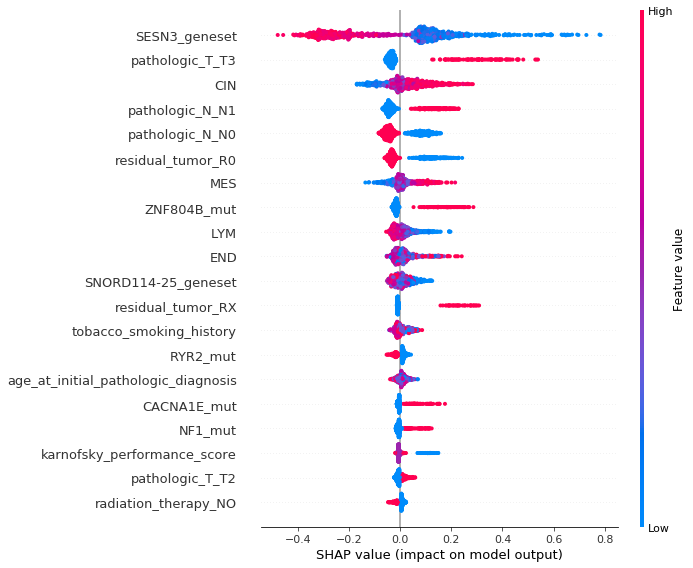

In [0]:
shap.summary_plot(shap_values, x_train_imp)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


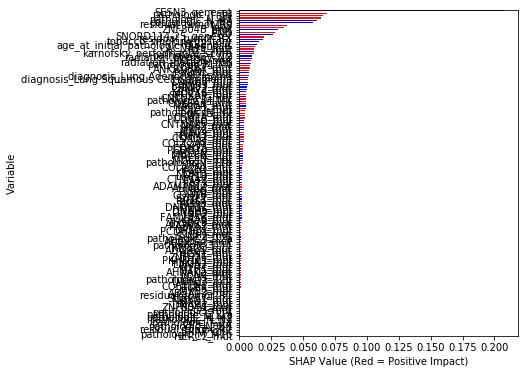

In [0]:

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,x_train_imp) 

In [0]:
dtest = xgb.DMatrix(x_test_imp)
pred = xgbmodel.predict(dtest)
print(pred[:10])

[0.44126648 0.7866649  0.96696013 0.47359854 0.4899666  1.0279934
 0.44092196 1.3907417  0.47264624 0.8944964 ]


In [0]:
pred_df = pd.DataFrame({
    "patient_id": x_test_imp.index.values,
    "risk_score": pred
})

pred_df.head()

,patient_id,risk_score
0,TEST_0000,0.441266
1,TEST_0001,0.786665
2,TEST_0002,0.966960
3,TEST_0003,0.473599
4,TEST_0004,0.489967


To submit, you will save the data frame as a `csv` file in the `submission` Google drive folder (https://drive.google.com/open?id=1bdW_Z7K2zlUSGWl4LbGIoPSn8EjNR3pt), using your UNI as the file name.

The following is the official scoring function that check the validity of your submission and give the concordance index.

In [0]:
def score_submission(df, pfs_test):
    if "patient_id" not in df.columns:
        raise ValueError(
            "Input data frame does not contain 'patient_id' column!"
        )
    
    if "risk_score" not in df.columns:
        raise ValueError(
            "Input data frame does not contain 'risk_score' column!"
        )

    df_ = df.merge(pfs_test, how="right")
    if not np.all(df_.risk_score.notnull()):
        raise ValueError(
            "Input data frame does not has risk scores for all patients!"
        )
    
    from lifelines.utils import concordance_index
    return concordance_index(df_.time_to_progression_or_censor,
                             df_.risk_score, df_.progression)

Let's see it in action. Note you will not have access to the `pfs_test.txt` file. But you can hold out your own test set to see if it's working in your pipeline.

In [0]:
# Load the test PFS data, you won't have access to this until the end of challenge
pfs_test = pd.read_csv("/content/drive/My Drive/mini-challenge_staging/pfs_test.txt",
                       sep="\t")

In [0]:
#pred_df.to_csv(DATA / "../submission/wc2302_baseline.csv")

In [0]:
score_submission(pred_df, pfs_test)